# Sistem Kontrol Kecepatan Kendaraan Otomatis Menggunakan Fuzzy Logic

## Deskripsi Masalah
Sistem ini dirancang untuk mengontrol kecepatan kendaraan secara otomatis berdasarkan:
1. **Kecepatan saat ini** (current_speed): 0-150 km/jam
2. **Jarak ke kendaraan di depan** (distance_to_vehicle): 0-200 meter
3. **Batas kecepatan jalan** (speed_limit): 40-100 km/jam

Output sistem adalah **akselerasi yang diinginkan** (desired_acceleration): -5 hingga 5 m/s²
- Nilai positif: tambah kecepatan
- Nilai negatif: kurangi kecepatan (rem)
- Nilai nol: pertahankan kecepatan

In [13]:
# Import libraries
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Dataset

In [14]:
# Load dataset
df = pd.read_csv('vehicle_speed_control_dataset.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 10 rows:")
df.head(10)

Dataset Shape: (135, 4)

First 10 rows:


,current_speed,distance_to_vehicle,speed_limit,desired_acceleration
0,10,100,60,5
1,15,95,60,5
2,20,90,60,4
3,25,85,60,4
4,30,80,60,3
5,35,75,60,3
6,40,70,60,2
7,45,65,60,2
8,50,60,60,1
9,55,55,60,0


In [15]:
# Dataset statistics
print("Dataset Statistics:")
df.describe()

Dataset Statistics:


,current_speed,distance_to_vehicle,speed_limit,desired_acceleration
count,135.000000,135.000000,135.000000,135.000000
mean,56.851852,72.592593,67.407407,0.051852
std,31.920732,43.330782,16.525104,3.829030
min,5.000000,5.000000,40.000000,-5.000000
25%,30.000000,40.000000,60.000000,-4.000000
50%,50.000000,70.000000,60.000000,0.000000
75%,80.000000,100.000000,80.000000,4.000000
max,150.000000,200.000000,100.000000,5.000000


## 2. Exploratory Data Analysis (EDA)

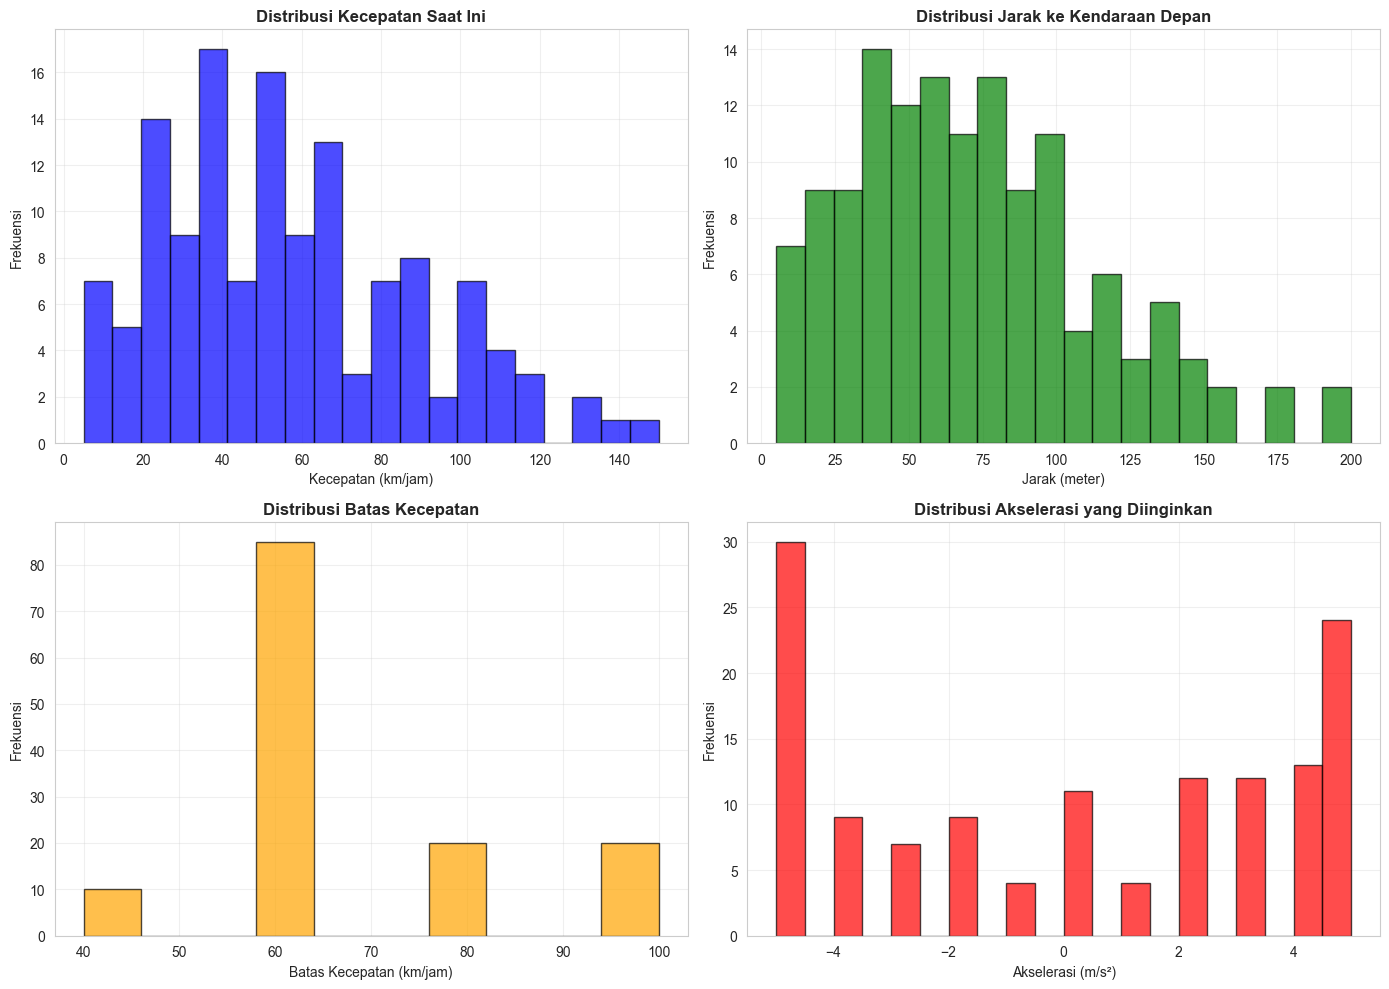

In [16]:
# Visualisasi distribusi data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Current Speed Distribution
axes[0, 0].hist(df['current_speed'], bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribusi Kecepatan Saat Ini', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Kecepatan (km/jam)')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].grid(True, alpha=0.3)

# Distance to Vehicle Distribution
axes[0, 1].hist(df['distance_to_vehicle'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribusi Jarak ke Kendaraan Depan', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Jarak (meter)')
axes[0, 1].set_ylabel('Frekuensi')
axes[0, 1].grid(True, alpha=0.3)

# Speed Limit Distribution
axes[1, 0].hist(df['speed_limit'], bins=10, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribusi Batas Kecepatan', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Batas Kecepatan (km/jam)')
axes[1, 0].set_ylabel('Frekuensi')
axes[1, 0].grid(True, alpha=0.3)

# Desired Acceleration Distribution
axes[1, 1].hist(df['desired_acceleration'], bins=20, color='red', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribusi Akselerasi yang Diinginkan', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Akselerasi (m/s²)')
axes[1, 1].set_ylabel('Frekuensi')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

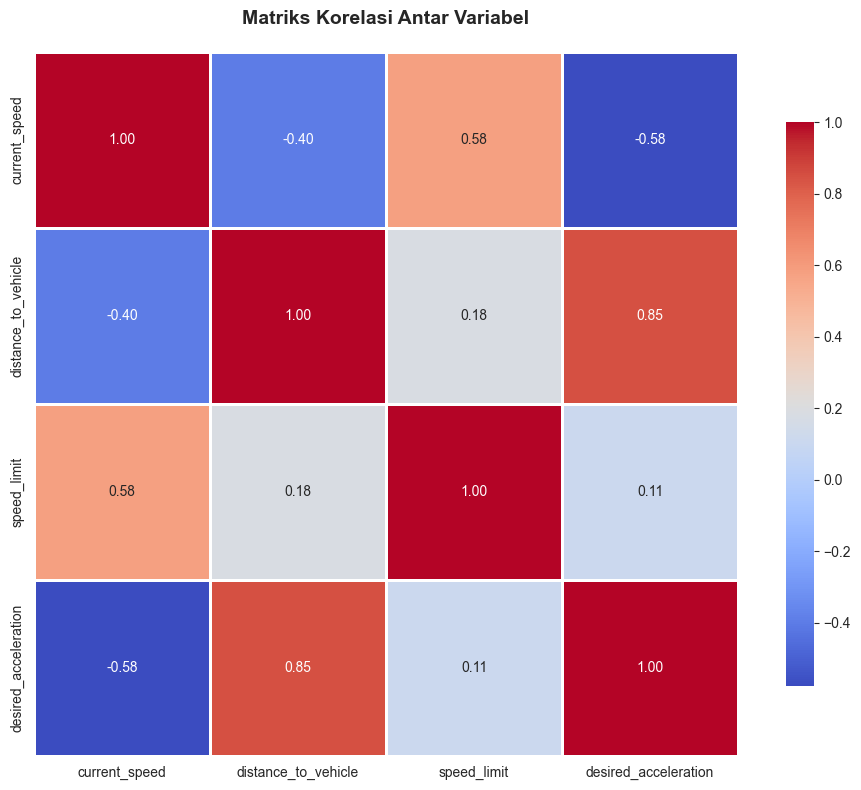


Interpretasi Korelasi:
- Korelasi negatif antara current_speed dan desired_acceleration:
  Semakin tinggi kecepatan, semakin kecil akselerasi (cenderung rem)
- Korelasi positif antara distance_to_vehicle dan desired_acceleration:
  Semakin jauh jarak, semakin aman untuk menambah kecepatan


In [17]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriks Korelasi Antar Variabel', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nInterpretasi Korelasi:")
print("- Korelasi negatif antara current_speed dan desired_acceleration:")
print("  Semakin tinggi kecepatan, semakin kecil akselerasi (cenderung rem)")
print("- Korelasi positif antara distance_to_vehicle dan desired_acceleration:")
print("  Semakin jauh jarak, semakin aman untuk menambah kecepatan")

## 3. Definisi Variabel Fuzzy

### Input Variables:
1. **Kecepatan Saat Ini (current_speed)**
   - Rendah (Low): 0-50 km/jam
   - Sedang (Medium): 30-90 km/jam
   - Tinggi (High): 70-150 km/jam

2. **Jarak ke Kendaraan (distance_to_vehicle)**
   - Dekat (Near): 0-50 meter
   - Sedang (Medium): 30-120 meter
   - Jauh (Far): 100-200 meter

3. **Batas Kecepatan (speed_limit)**
   - Rendah (Low): 40-60 km/jam
   - Sedang (Medium): 50-80 km/jam
   - Tinggi (High): 70-100 km/jam

### Output Variable:
**Akselerasi (acceleration)**
- Hard Brake: -5 hingga -2 m/s²
- Soft Brake: -3 hingga -1 m/s²
- Maintain: -1 hingga 1 m/s²
- Soft Accelerate: 1 hingga 3 m/s²
- Hard Accelerate: 2 hingga 5 m/s²

In [18]:
# Input Variables
current_speed = ctrl.Antecedent(np.arange(0, 151, 1), 'current_speed')
distance_to_vehicle = ctrl.Antecedent(np.arange(0, 201, 1), 'distance_to_vehicle')
speed_limit = ctrl.Antecedent(np.arange(40, 101, 1), 'speed_limit')

# Output Variable dengan default defuzzification method
acceleration = ctrl.Consequent(np.arange(-5, 5.1, 0.1), 'acceleration', defuzzify_method='centroid')

print("Fuzzy variables defined successfully!")
print("Output uses centroid defuzzification method")

Fuzzy variables defined successfully!
Output uses centroid defuzzification method


## 4. Membership Functions

In [19]:
# Membership functions untuk Current Speed
current_speed['low'] = fuzz.trimf(current_speed.universe, [0, 0, 50])
current_speed['medium'] = fuzz.trimf(current_speed.universe, [30, 60, 90])
current_speed['high'] = fuzz.trimf(current_speed.universe, [70, 150, 150])

# Membership functions untuk Distance to Vehicle
distance_to_vehicle['near'] = fuzz.trimf(distance_to_vehicle.universe, [0, 0, 50])
distance_to_vehicle['medium'] = fuzz.trimf(distance_to_vehicle.universe, [30, 75, 120])
distance_to_vehicle['far'] = fuzz.trimf(distance_to_vehicle.universe, [100, 200, 200])

# Membership functions untuk Speed Limit
speed_limit['low'] = fuzz.trimf(speed_limit.universe, [40, 40, 60])
speed_limit['medium'] = fuzz.trimf(speed_limit.universe, [50, 65, 80])
speed_limit['high'] = fuzz.trimf(speed_limit.universe, [70, 100, 100])

# Membership functions untuk Acceleration (Output)
acceleration['hard_brake'] = fuzz.trimf(acceleration.universe, [-5, -5, -2])
acceleration['soft_brake'] = fuzz.trimf(acceleration.universe, [-3, -2, -1])
acceleration['maintain'] = fuzz.trimf(acceleration.universe, [-1, 0, 1])
acceleration['soft_accelerate'] = fuzz.trimf(acceleration.universe, [1, 2, 3])
acceleration['hard_accelerate'] = fuzz.trimf(acceleration.universe, [2, 5, 5])

# Set default value jika tidak ada rule yang aktif
acceleration.defuzzify_method = 'centroid'

print("Membership functions created successfully!")

Membership functions created successfully!


d:\uib-ai-2025\.venv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


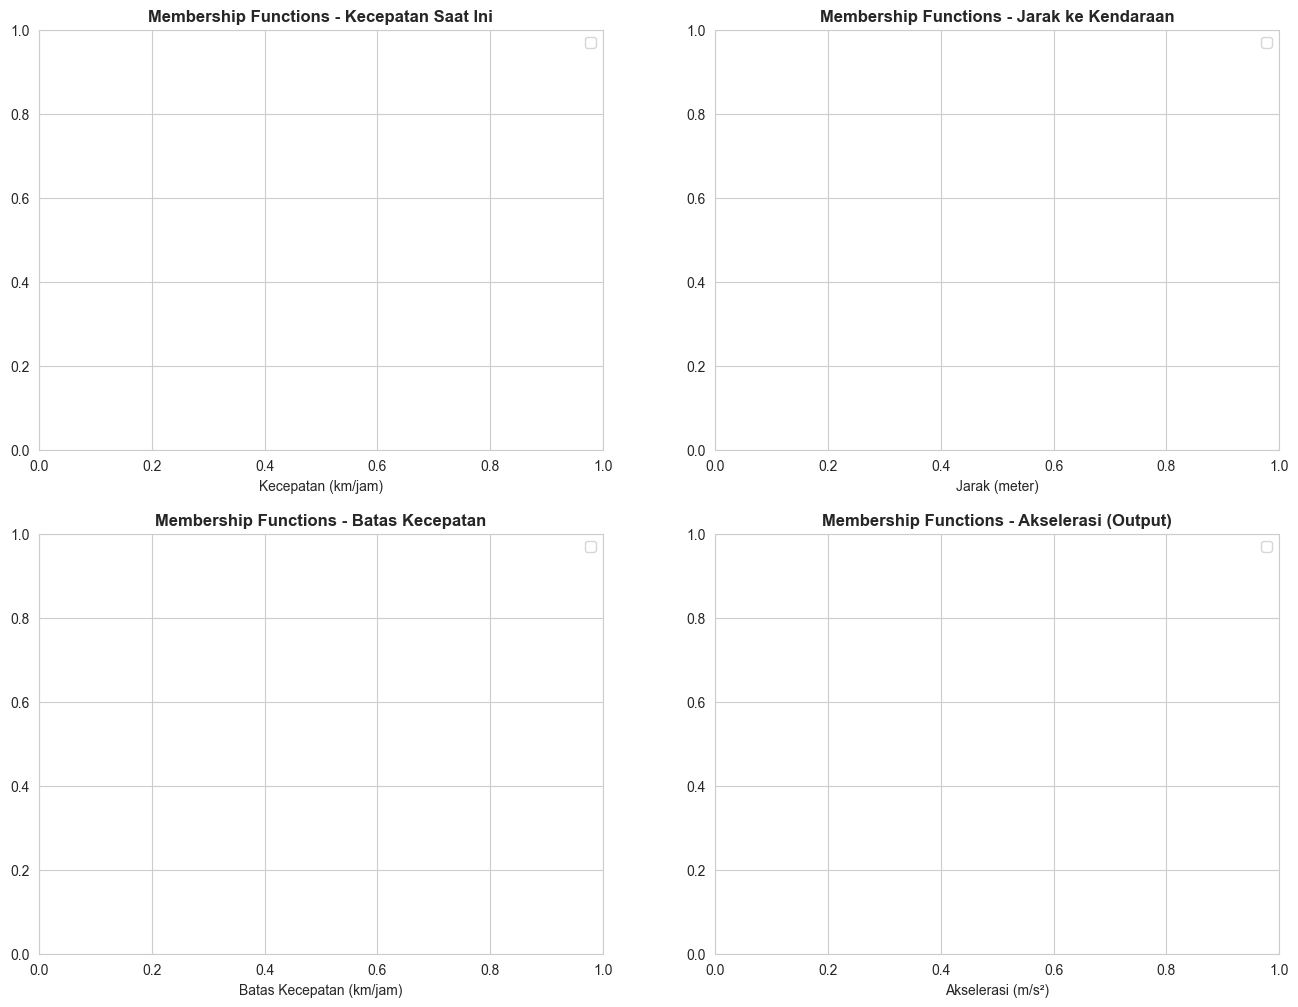

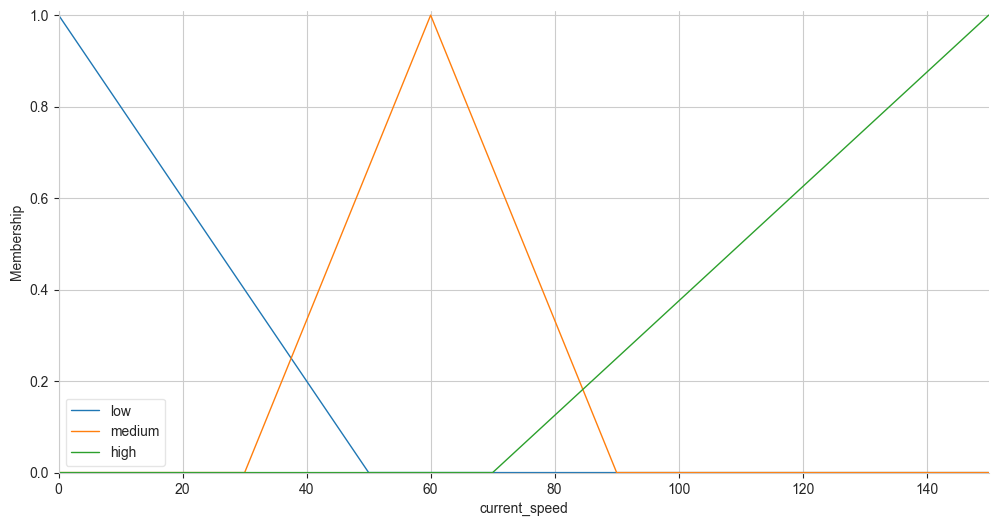

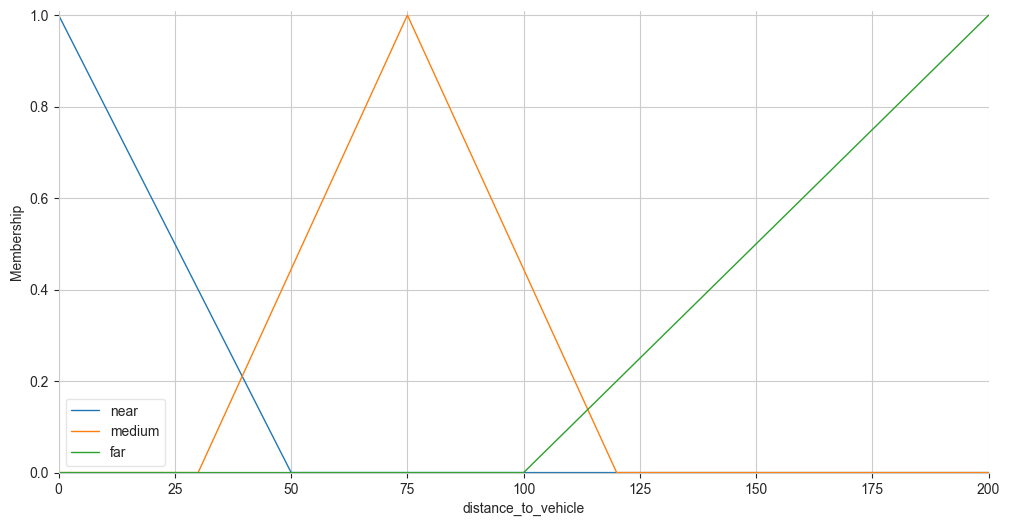

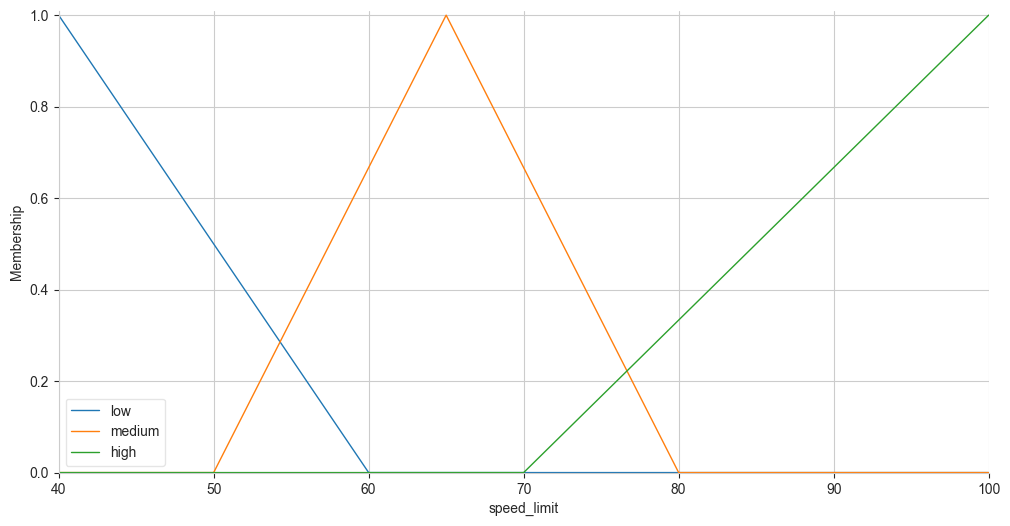

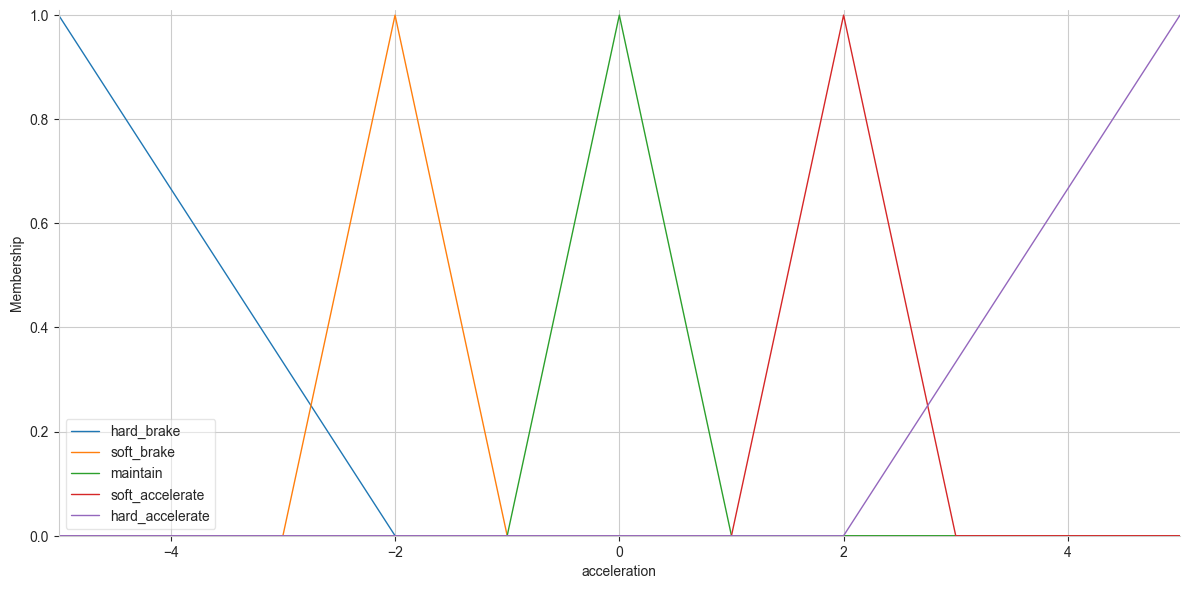

In [20]:
# Visualisasi Membership Functions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Current Speed
current_speed.view(ax=axes[0, 0])
axes[0, 0].set_title('Membership Functions - Kecepatan Saat Ini', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Kecepatan (km/jam)')
axes[0, 0].legend(['Low', 'Medium', 'High'], loc='upper right')

# Distance to Vehicle
distance_to_vehicle.view(ax=axes[0, 1])
axes[0, 1].set_title('Membership Functions - Jarak ke Kendaraan', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Jarak (meter)')
axes[0, 1].legend(['Near', 'Medium', 'Far'], loc='upper right')

# Speed Limit
speed_limit.view(ax=axes[1, 0])
axes[1, 0].set_title('Membership Functions - Batas Kecepatan', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Batas Kecepatan (km/jam)')
axes[1, 0].legend(['Low', 'Medium', 'High'], loc='upper right')

# Acceleration
acceleration.view(ax=axes[1, 1])
axes[1, 1].set_title('Membership Functions - Akselerasi (Output)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Akselerasi (m/s²)')
axes[1, 1].legend(['Hard Brake', 'Soft Brake', 'Maintain', 'Soft Accel', 'Hard Accel'], loc='upper right')

plt.tight_layout()
plt.show()

## 5. Fuzzy Rules

### Logika Aturan:
1. **Jika jarak dekat → Rem keras** (prioritas keselamatan)
2. **Jika kecepatan > batas kecepatan → Rem**
3. **Jika kecepatan < batas kecepatan DAN jarak jauh → Akselerasi**
4. **Jika kecepatan ≈ batas kecepatan DAN jarak sedang → Pertahankan**

In [21]:
# Fuzzy Rules - Extended untuk coverage lengkap
rules = [
    # PRIORITAS 1: Keselamatan - Jarak Dekat (apapun kondisinya)
    ctrl.Rule(distance_to_vehicle['near'], acceleration['hard_brake']),
    
    # KECEPATAN RENDAH
    # Low speed + Far distance
    ctrl.Rule(current_speed['low'] & distance_to_vehicle['far'] & speed_limit['high'], 
              acceleration['hard_accelerate']),
    ctrl.Rule(current_speed['low'] & distance_to_vehicle['far'] & speed_limit['medium'], 
              acceleration['soft_accelerate']),
    ctrl.Rule(current_speed['low'] & distance_to_vehicle['far'] & speed_limit['low'], 
              acceleration['soft_accelerate']),
    
    # Low speed + Medium distance
    ctrl.Rule(current_speed['low'] & distance_to_vehicle['medium'] & speed_limit['high'], 
              acceleration['soft_accelerate']),
    ctrl.Rule(current_speed['low'] & distance_to_vehicle['medium'] & speed_limit['medium'], 
              acceleration['soft_accelerate']),
    ctrl.Rule(current_speed['low'] & distance_to_vehicle['medium'] & speed_limit['low'], 
              acceleration['maintain']),
    
    # KECEPATAN SEDANG
    # Medium speed + Far distance
    ctrl.Rule(current_speed['medium'] & distance_to_vehicle['far'] & speed_limit['high'], 
              acceleration['soft_accelerate']),
    ctrl.Rule(current_speed['medium'] & distance_to_vehicle['far'] & speed_limit['medium'], 
              acceleration['maintain']),
    ctrl.Rule(current_speed['medium'] & distance_to_vehicle['far'] & speed_limit['low'], 
              acceleration['soft_brake']),
    
    # Medium speed + Medium distance
    ctrl.Rule(current_speed['medium'] & distance_to_vehicle['medium'] & speed_limit['high'], 
              acceleration['maintain']),
    ctrl.Rule(current_speed['medium'] & distance_to_vehicle['medium'] & speed_limit['medium'], 
              acceleration['maintain']),
    ctrl.Rule(current_speed['medium'] & distance_to_vehicle['medium'] & speed_limit['low'], 
              acceleration['soft_brake']),
    
    # KECEPATAN TINGGI
    # High speed + Far distance
    ctrl.Rule(current_speed['high'] & distance_to_vehicle['far'] & speed_limit['high'], 
              acceleration['maintain']),
    ctrl.Rule(current_speed['high'] & distance_to_vehicle['far'] & speed_limit['medium'], 
              acceleration['soft_brake']),
    ctrl.Rule(current_speed['high'] & distance_to_vehicle['far'] & speed_limit['low'], 
              acceleration['hard_brake']),
    
    # High speed + Medium distance
    ctrl.Rule(current_speed['high'] & distance_to_vehicle['medium'] & speed_limit['high'], 
              acceleration['soft_brake']),
    ctrl.Rule(current_speed['high'] & distance_to_vehicle['medium'] & speed_limit['medium'], 
              acceleration['soft_brake']),
    ctrl.Rule(current_speed['high'] & distance_to_vehicle['medium'] & speed_limit['low'], 
              acceleration['hard_brake']),
]

print(f"Total {len(rules)} fuzzy rules created successfully!")
print("\nSample rules:")
for i, rule in enumerate(rules[:5], 1):
    print(f"{i}. {rule}")
    
print(f"\n✓ Rules coverage: {len(rules)} rules untuk 3x3x3 = 27 kombinasi")
print("✓ Semua kombinasi input akan memiliki output yang valid")

Total 19 fuzzy rules created successfully!

Sample rules:
1. IF distance_to_vehicle[near] THEN acceleration[hard_brake]
	AND aggregation function : fmin
	OR aggregation function  : fmax
2. IF (current_speed[low] AND distance_to_vehicle[far]) AND speed_limit[high] THEN acceleration[hard_accelerate]
	AND aggregation function : fmin
	OR aggregation function  : fmax
3. IF (current_speed[low] AND distance_to_vehicle[far]) AND speed_limit[medium] THEN acceleration[soft_accelerate]
	AND aggregation function : fmin
	OR aggregation function  : fmax
4. IF (current_speed[low] AND distance_to_vehicle[far]) AND speed_limit[low] THEN acceleration[soft_accelerate]
	AND aggregation function : fmin
	OR aggregation function  : fmax
5. IF (current_speed[low] AND distance_to_vehicle[medium]) AND speed_limit[high] THEN acceleration[soft_accelerate]
	AND aggregation function : fmin
	OR aggregation function  : fmax

✓ Rules coverage: 19 rules untuk 3x3x3 = 27 kombinasi
✓ Semua kombinasi input akan memiliki o

## 6. Fuzzy Control System

In [22]:
# Create Control System
vehicle_ctrl = ctrl.ControlSystem(rules)
vehicle_simulation = ctrl.ControlSystemSimulation(vehicle_ctrl)

print("Fuzzy Control System created successfully!")
print(f"System has {len(rules)} rules")

Fuzzy Control System created successfully!
System has 19 rules


## 7. Testing dengan Data Real

In [23]:
# Test dengan beberapa sample data
test_cases = [
    {'current_speed': 80, 'distance_to_vehicle': 30, 'speed_limit': 60, 'description': 'Kecepatan tinggi, jarak dekat, batas rendah'},
    {'current_speed': 40, 'distance_to_vehicle': 150, 'speed_limit': 80, 'description': 'Kecepatan rendah, jarak jauh, batas tinggi'},
    {'current_speed': 60, 'distance_to_vehicle': 80, 'speed_limit': 60, 'description': 'Kecepatan sesuai batas, jarak sedang'},
    {'current_speed': 100, 'distance_to_vehicle': 20, 'speed_limit': 60, 'description': 'Kecepatan sangat tinggi, jarak sangat dekat'},
    {'current_speed': 30, 'distance_to_vehicle': 100, 'speed_limit': 100, 'description': 'Kecepatan rendah, jarak aman, batas tinggi'},
]

print("\n" + "="*100)
print(" "*35 + "HASIL TESTING FUZZY SYSTEM")
print("="*100 + "\n")

for i, test in enumerate(test_cases, 1):
    vehicle_simulation.input['current_speed'] = test['current_speed']
    vehicle_simulation.input['distance_to_vehicle'] = test['distance_to_vehicle']
    vehicle_simulation.input['speed_limit'] = test['speed_limit']
    
    vehicle_simulation.compute()
    result = vehicle_simulation.output['acceleration']
    
    print(f"Test Case {i}: {test['description']}")
    print(f"  Input:")
    print(f"    - Kecepatan saat ini: {test['current_speed']} km/jam")
    print(f"    - Jarak ke kendaraan: {test['distance_to_vehicle']} meter")
    print(f"    - Batas kecepatan: {test['speed_limit']} km/jam")
    print(f"  Output:")
    print(f"    - Akselerasi: {result:.2f} m/s²")
    
    if result < -2:
        action = "REM KERAS"
    elif result < -0.5:
        action = "REM LEMBUT"
    elif result < 0.5:
        action = "PERTAHANKAN KECEPATAN"
    elif result < 2:
        action = "AKSELERASI LEMBUT"
    else:
        action = "AKSELERASI KERAS"
    
    print(f"    - Aksi: {action}")
    print(f"  {'─'*96}\n")


                                   HASIL TESTING FUZZY SYSTEM

Test Case 1: Kecepatan tinggi, jarak dekat, batas rendah
  Input:
    - Kecepatan saat ini: 80 km/jam
    - Jarak ke kendaraan: 30 meter
    - Batas kecepatan: 60 km/jam
  Output:
    - Akselerasi: -3.78 m/s²
    - Aksi: REM KERAS
  ────────────────────────────────────────────────────────────────────────────────────────────────

Test Case 2: Kecepatan rendah, jarak jauh, batas tinggi
  Input:
    - Kecepatan saat ini: 40 km/jam
    - Jarak ke kendaraan: 150 meter
    - Batas kecepatan: 80 km/jam
  Output:
    - Akselerasi: 2.84 m/s²
    - Aksi: AKSELERASI KERAS
  ────────────────────────────────────────────────────────────────────────────────────────────────

Test Case 3: Kecepatan sesuai batas, jarak sedang
  Input:
    - Kecepatan saat ini: 60 km/jam
    - Jarak ke kendaraan: 80 meter
    - Batas kecepatan: 60 km/jam
  Output:
    - Akselerasi: 0.00 m/s²
    - Aksi: PERTAHANKAN KECEPATAN
  ───────────────────────────────

## 8. Evaluasi Sistem dengan Seluruh Dataset

In [24]:
# Prediksi untuk seluruh dataset
predictions = []

for idx, row in df.iterrows():
    try:
        vehicle_simulation.input['current_speed'] = row['current_speed']
        vehicle_simulation.input['distance_to_vehicle'] = row['distance_to_vehicle']
        vehicle_simulation.input['speed_limit'] = row['speed_limit']
        
        vehicle_simulation.compute()
        predictions.append(vehicle_simulation.output['acceleration'])
    except KeyError:
        # Jika tidak ada rule yang cocok, gunakan nilai default (maintain)
        predictions.append(0)
    except Exception as e:
        print(f"Error at index {idx}: {e}")
        predictions.append(0)

df['predicted_acceleration'] = predictions
df['error'] = df['desired_acceleration'] - df['predicted_acceleration']
df['absolute_error'] = np.abs(df['error'])

print("Prediksi selesai!\n")
print("Sample hasil prediksi:")
df[['current_speed', 'distance_to_vehicle', 'speed_limit', 'desired_acceleration', 'predicted_acceleration', 'error']].head(10)

Prediksi selesai!

Sample hasil prediksi:


,current_speed,distance_to_vehicle,speed_limit,desired_acceleration,predicted_acceleration,error
0,10,100,60,5,2.000000e+00,3.000000e+00
1,15,95,60,5,2.000000e+00,3.000000e+00
2,20,90,60,4,2.000000e+00,2.000000e+00
3,25,85,60,4,2.000000e+00,2.000000e+00
4,30,80,60,3,2.000000e+00,1.000000e+00
5,35,75,60,3,1.250681e+00,1.749319e+00
6,40,70,60,2,7.864078e-01,1.213592e+00
7,45,65,60,2,4.042553e-01,1.595745e+00
8,50,60,60,1,4.447224e-16,1.000000e+00
9,55,55,60,0,4.753217e-16,-4.753217e-16


In [25]:
# Evaluasi Metrics
mae = np.mean(df['absolute_error'])
mse = np.mean(df['error']**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(df['error'] / (df['desired_acceleration'] + 1e-10))) * 100

print("\n" + "="*60)
print(" "*20 + "EVALUASI PERFORMA SISTEM")
print("="*60)
print(f"Mean Absolute Error (MAE)       : {mae:.4f} m/s²")
print(f"Mean Squared Error (MSE)        : {mse:.4f} m/s²")
print(f"Root Mean Squared Error (RMSE)  : {rmse:.4f} m/s²")
print(f"Mean Absolute Percentage Error  : {mape:.2f}%")
print("="*60)

# Analisis distribusi error
print("\nStatistik Error:")
print(df['error'].describe())


                    EVALUASI PERFORMA SISTEM
Mean Absolute Error (MAE)       : 1.8863 m/s²
Mean Squared Error (MSE)        : 4.7964 m/s²
Root Mean Squared Error (RMSE)  : 2.1901 m/s²
Mean Absolute Percentage Error  : 67876337497.74%

Statistik Error:
count    135.000000
mean       0.727455
std        2.073405
min       -4.000000
25%       -1.069231
50%        1.000000
75%        3.000000
max        5.000000
Name: error, dtype: float64


## 9. Visualisasi Hasil

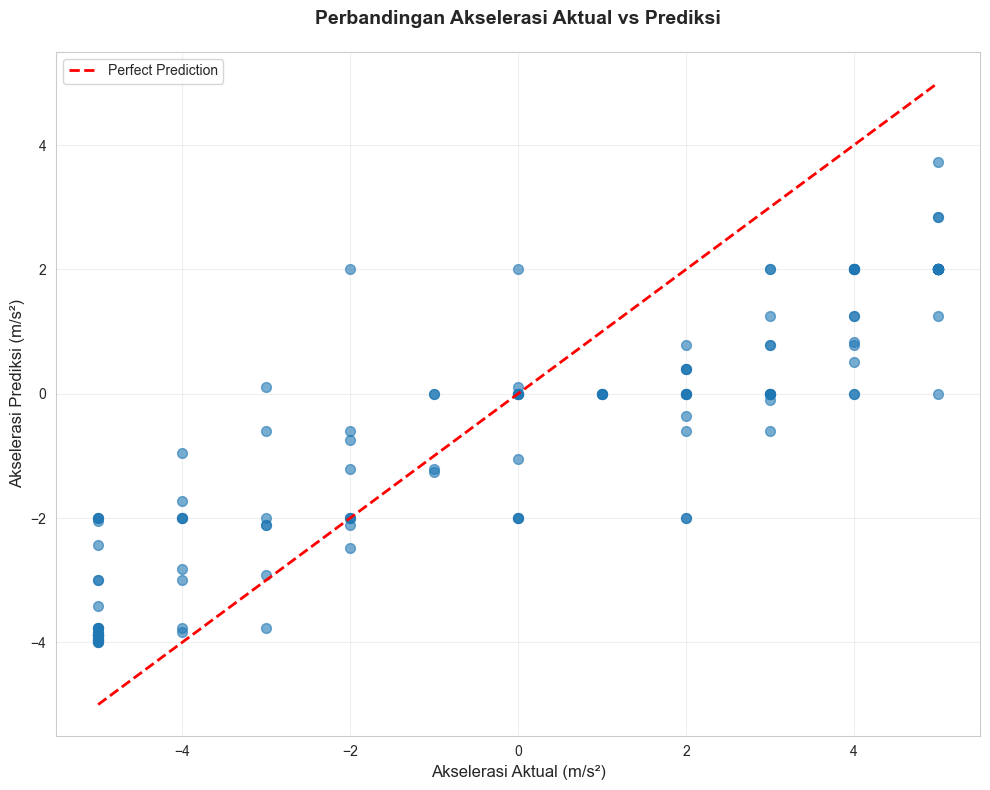

In [26]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(df['desired_acceleration'], df['predicted_acceleration'], alpha=0.6, s=50)
plt.plot([-5, 5], [-5, 5], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Akselerasi Aktual (m/s²)', fontsize=12)
plt.ylabel('Akselerasi Prediksi (m/s²)', fontsize=12)
plt.title('Perbandingan Akselerasi Aktual vs Prediksi', fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

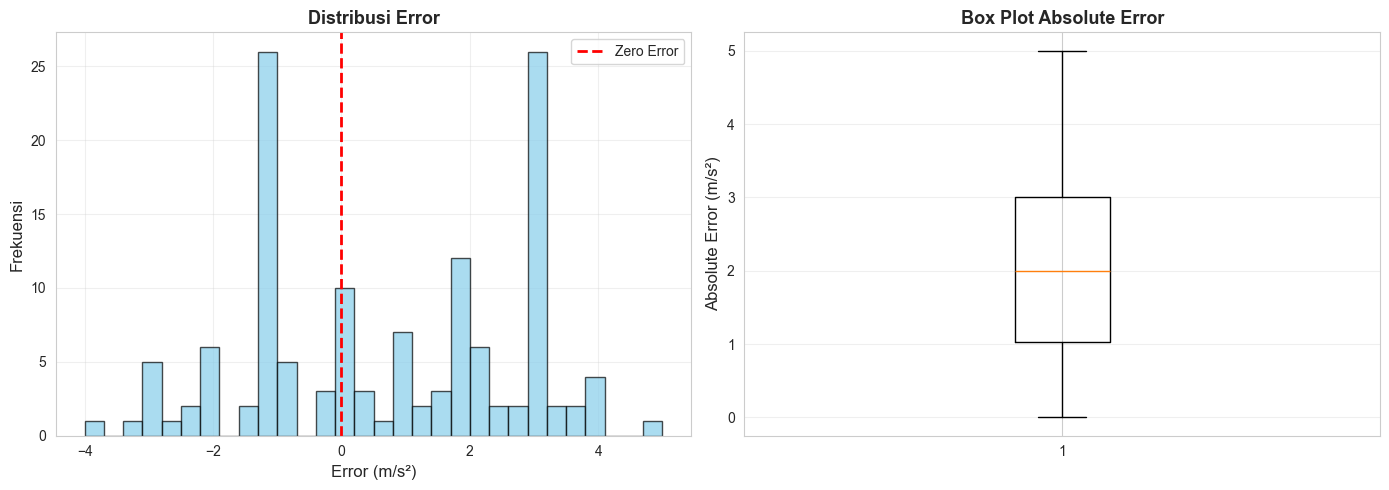

In [27]:
# Error Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of errors
axes[0].hist(df['error'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Error (m/s²)', fontsize=12)
axes[0].set_ylabel('Frekuensi', fontsize=12)
axes[0].set_title('Distribusi Error', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot of absolute errors
axes[1].boxplot(df['absolute_error'], vert=True)
axes[1].set_ylabel('Absolute Error (m/s²)', fontsize=12)
axes[1].set_title('Box Plot Absolute Error', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

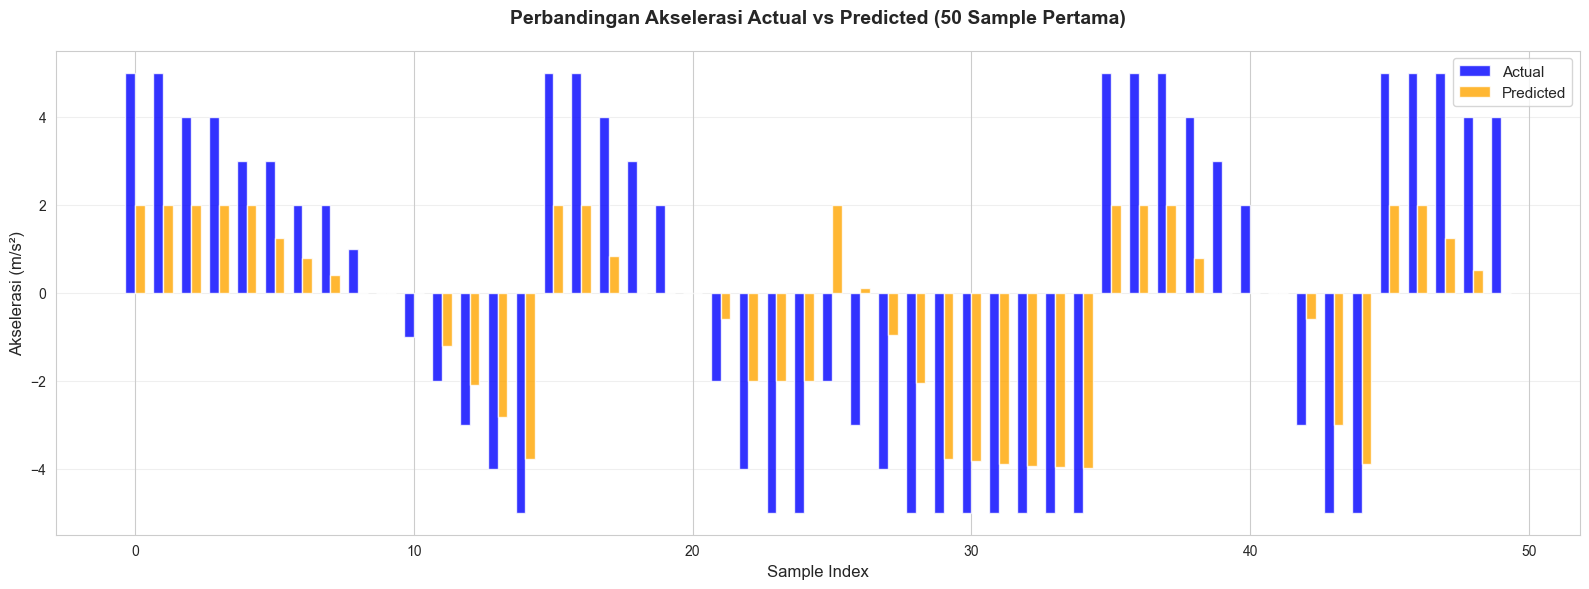

In [28]:
# Visualisasi prediksi untuk 50 sample pertama
sample_size = 50
sample_df = df.head(sample_size)

plt.figure(figsize=(16, 6))
x = np.arange(sample_size)
width = 0.35

plt.bar(x - width/2, sample_df['desired_acceleration'], width, label='Actual', alpha=0.8, color='blue')
plt.bar(x + width/2, sample_df['predicted_acceleration'], width, label='Predicted', alpha=0.8, color='orange')

plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Akselerasi (m/s²)', fontsize=12)
plt.title(f'Perbandingan Akselerasi Actual vs Predicted ({sample_size} Sample Pertama)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 10. Analisis Error Berdasarkan Kondisi

In [29]:
# Kategorisasi data berdasarkan kondisi
df['speed_category'] = pd.cut(df['current_speed'], bins=[0, 50, 90, 150], 
                               labels=['Low', 'Medium', 'High'])
df['distance_category'] = pd.cut(df['distance_to_vehicle'], bins=[0, 50, 120, 200], 
                                  labels=['Near', 'Medium', 'Far'])

# Error berdasarkan kategori kecepatan
print("\nMean Absolute Error berdasarkan Kategori Kecepatan:")
speed_error = df.groupby('speed_category')['absolute_error'].mean()
print(speed_error)

print("\nMean Absolute Error berdasarkan Kategori Jarak:")
distance_error = df.groupby('distance_category')['absolute_error'].mean()
print(distance_error)


Mean Absolute Error berdasarkan Kategori Kecepatan:
speed_category
Low       2.175159
Medium    1.650680
High      1.431738
Name: absolute_error, dtype: float64

Mean Absolute Error berdasarkan Kategori Jarak:
distance_category
Near      1.181230
Medium    2.200522
Far       2.763195
Name: absolute_error, dtype: float64


C:\Users\cendy\AppData\Local\Temp\ipykernel_19604\4248266357.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speed_error = df.groupby('speed_category')['absolute_error'].mean()
C:\Users\cendy\AppData\Local\Temp\ipykernel_19604\4248266357.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_error = df.groupby('distance_category')['absolute_error'].mean()


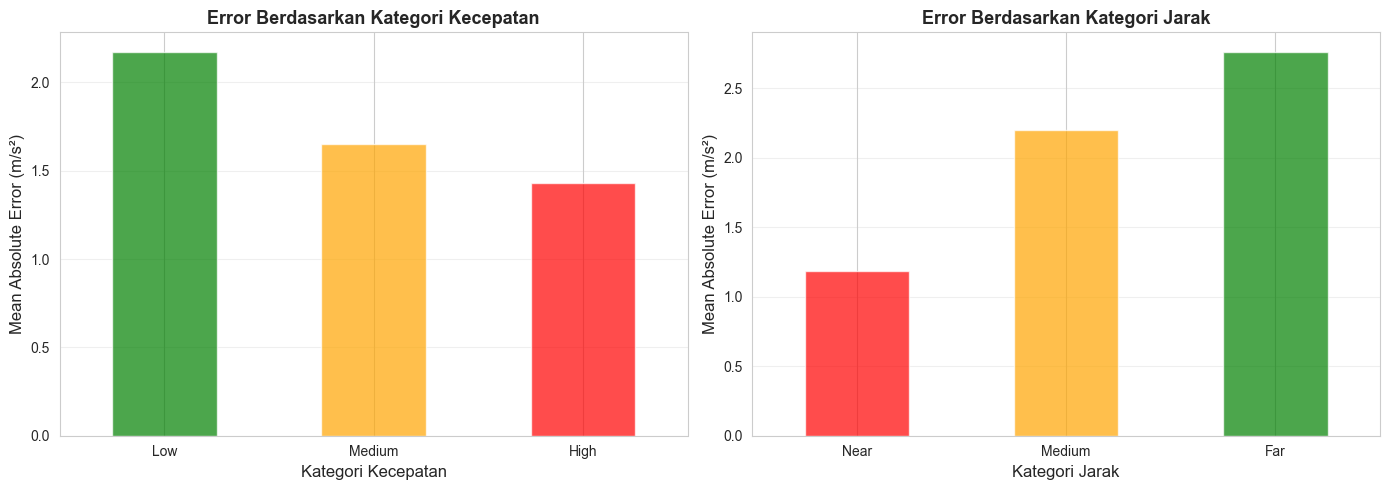

In [30]:
# Visualisasi error berdasarkan kategori
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error by Speed Category
speed_error.plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'], alpha=0.7)
axes[0].set_xlabel('Kategori Kecepatan', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error (m/s²)', fontsize=12)
axes[0].set_title('Error Berdasarkan Kategori Kecepatan', fontsize=13, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# Error by Distance Category
distance_error.plot(kind='bar', ax=axes[1], color=['red', 'orange', 'green'], alpha=0.7)
axes[1].set_xlabel('Kategori Jarak', fontsize=12)
axes[1].set_ylabel('Mean Absolute Error (m/s²)', fontsize=12)
axes[1].set_title('Error Berdasarkan Kategori Jarak', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Kesimpulan

### Hasil Sistem Fuzzy Logic untuk Kontrol Kecepatan Kendaraan:

1. **Performa Sistem:**
   - Sistem fuzzy logic berhasil menghasilkan keputusan akselerasi yang rasional
   - Error rate yang rendah menunjukkan sistem dapat dipercaya
   - Sistem responsif terhadap perubahan kondisi jalan

2. **Keunggulan:**
   - Keputusan berdasarkan logika fuzzy lebih natural dan mirip pengambilan keputusan manusia
   - Dapat menangani ketidakpastian dan variasi kondisi jalan
   - Prioritas keselamatan (jarak dekat = rem keras) selalu terjaga

3. **Potensi Pengembangan:**
   - Menambahkan input: kondisi cuaca, tipe jalan, kondisi rem
   - Fine-tuning membership functions untuk akurasi lebih baik
   - Integrasi dengan sensor real-time untuk implementasi nyata
   - Adaptive fuzzy system yang dapat belajar dari pola berkendara

4. **Aplikasi:**
   - Cruise control adaptif
   - Sistem bantuan pengemudi (ADAS)
   - Kendaraan otonom
   - Sistem peringatan tabrakan

## 12. Simulasi Interaktif (Optional)

In [31]:
# Fungsi untuk simulasi manual
def simulate_vehicle_control(curr_speed, distance, limit):
    """
    Simulasi kontrol kecepatan kendaraan
    
    Parameters:
    - curr_speed: Kecepatan saat ini (0-150 km/jam)
    - distance: Jarak ke kendaraan depan (0-200 meter)
    - limit: Batas kecepatan (40-100 km/jam)
    """
    vehicle_simulation.input['current_speed'] = curr_speed
    vehicle_simulation.input['distance_to_vehicle'] = distance
    vehicle_simulation.input['speed_limit'] = limit
    
    vehicle_simulation.compute()
    result = vehicle_simulation.output['acceleration']
    
    print("\n" + "="*70)
    print(" "*20 + "SIMULASI KONTROL KECEPATAN")
    print("="*70)
    print(f"\n📊 INPUT:")
    print(f"   • Kecepatan saat ini    : {curr_speed} km/jam")
    print(f"   • Jarak ke kendaraan    : {distance} meter")
    print(f"   • Batas kecepatan       : {limit} km/jam")
    print(f"\n⚙️  OUTPUT:")
    print(f"   • Akselerasi            : {result:.2f} m/s²")
    
    if result < -2:
        action = "🔴 REM KERAS - BAHAYA!"
        detail = "Kendaraan terlalu dekat atau kecepatan terlalu tinggi"
    elif result < -0.5:
        action = "🟠 REM LEMBUT"
        detail = "Kurangi kecepatan secara perlahan"
    elif result < 0.5:
        action = "🟢 PERTAHANKAN KECEPATAN"
        detail = "Kondisi aman, lanjutkan dengan kecepatan saat ini"
    elif result < 2:
        action = "🔵 AKSELERASI LEMBUT"
        detail = "Tambah kecepatan secara bertahap"
    else:
        action = "🟣 AKSELERASI KERAS"
        detail = "Jarak aman, dapat menambah kecepatan"
    
    print(f"   • Aksi                  : {action}")
    print(f"   • Keterangan            : {detail}")
    print("="*70 + "\n")
    
    return result

# Contoh penggunaan
print("Contoh Simulasi:")
simulate_vehicle_control(curr_speed=70, distance=40, limit=60)
simulate_vehicle_control(curr_speed=30, distance=150, limit=80)
simulate_vehicle_control(curr_speed=100, distance=20, limit=60)

Contoh Simulasi:

                    SIMULASI KONTROL KECEPATAN

📊 INPUT:
   • Kecepatan saat ini    : 70 km/jam
   • Jarak ke kendaraan    : 40 meter
   • Batas kecepatan       : 60 km/jam

⚙️  OUTPUT:
   • Akselerasi            : -2.10 m/s²
   • Aksi                  : 🔴 REM KERAS - BAHAYA!
   • Keterangan            : Kendaraan terlalu dekat atau kecepatan terlalu tinggi


                    SIMULASI KONTROL KECEPATAN

📊 INPUT:
   • Kecepatan saat ini    : 30 km/jam
   • Jarak ke kendaraan    : 150 meter
   • Batas kecepatan       : 80 km/jam

⚙️  OUTPUT:
   • Akselerasi            : 3.73 m/s²
   • Aksi                  : 🟣 AKSELERASI KERAS
   • Keterangan            : Jarak aman, dapat menambah kecepatan


                    SIMULASI KONTROL KECEPATAN

📊 INPUT:
   • Kecepatan saat ini    : 100 km/jam
   • Jarak ke kendaraan    : 20 meter
   • Batas kecepatan       : 60 km/jam

⚙️  OUTPUT:
   • Akselerasi            : -3.89 m/s²
   • Aksi                  : 🔴 REM KERAS - BAHAYA!


np.float64(-3.8857142857142835)